In [ ]:
from google.colab import drive
drive.mount('/Til')

Drive already mounted at /Til; to attempt to forcibly remount, call drive.mount("/Til", force_remount=True).


In [ ]:
!pip install transformers sentencepiece sacrebleu -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
import json
import random

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar  1 14:54:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    47W / 400W |  13783MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
from transformers import MBartForConditionalGeneration, MBart50Tokenizer

In [ ]:
base_model_path = '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-qm-raw'

In [ ]:
tokenizer = MBart50Tokenizer.from_pretrained(base_model_path)

In [ ]:
old_len = len(tokenizer)
old_len

252291

Because language ids are added by hard-code on initialization, we need to manually fix them.

In [ ]:
tokenizer.lang_code_to_id['qm_XX'] = old_len-1
tokenizer.id_to_lang_code[old_len-1] = 'qm_XX'
tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
if 'qm_XX' not in tokenizer.additional_special_tokens:
    tokenizer.additional_special_tokens.append('qm_XX')

In [ ]:
all_sent = pd.read_csv('/Til/MyDrive/Colab Notebooks/Til/Data/Bary_bir_to_model.csv')
all_pairs = list()
for i in range(len(all_sent)):
    all_pairs.append(all_sent.iloc[i].tolist())

## Training

In [ ]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [ ]:
model = MBartForConditionalGeneration.from_pretrained(base_model_path)

In [ ]:
model.cuda();

### First, update just the new embeddings

In [ ]:
for p in model.parameters():
    p.requires_grad = False
for p in model.model.shared.parameters():
    p.requires_grad = True

In [ ]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-5,
    clip_threshold=1.0
)

In [ ]:
batch_size = 8  
report_steps = 500 
epochs = 1
losses = []

In [ ]:
tokenizer.src_lang = "qm_XX"
tokenizer.tgt_lang = "ru_RU"

In [ ]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

EPOCH 0


  0%|          | 0/3404 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


step 0 loss 12.203435897827148
step 500 loss 9.093794898986816
step 1000 loss 3.811146618127823
step 1500 loss 2.375310741901398
step 2000 loss 2.161080859184265
step 2500 loss 2.0334278306961058
step 3000 loss 1.9426452250480652


Normal translation/paraphrasing loss is typically about 0.5 to 1 in mBART, so here I expect something similar after some fine-tuning.

In [ ]:
save_model_path = '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-qm-ru-v1'

In [ ]:
model.save_pretrained(save_model_path)
tokenizer.save_pretrained(save_model_path)

('/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-qm-ru-v1/tokenizer_config.json',
 '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-qm-ru-v1/special_tokens_map.json',
 '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-qm-ru-v1/sentencepiece.bpe.model',
 '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-qm-ru-v1/added_tokens.json')

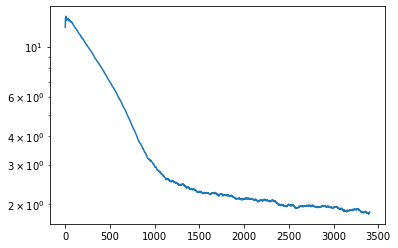

In [ ]:
import matplotlib.pyplot as plt
pd.Series(losses).ewm(100).mean().plot();
plt.yscale('log');

### Now update the whole model, with embeddings and transformer layers.

In [ ]:
loss = None
optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()

In [ ]:
for p in model.parameters():
    p.requires_grad = True

In [ ]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-6,
    clip_threshold=1.0
)

In [ ]:
batch_size = 8
report_steps = 200 
epochs = 21
losses = []
print(len(all_pairs)/batch_size)

3404.375


Optimizing all parameters takes x2 longer than just embeddings: about 1h per epoch. 

In [ ]:
#cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

EPOCH 0


  0%|          | 0/3404 [00:00<?, ?it/s]

step 0 loss 0.8442345389723778
step 200 loss 0.8587588267028332
step 400 loss 0.8282198694348335
step 600 loss 0.8474766047298908
step 800 loss 0.885417921692133
step 1000 loss 0.8747356335818768
step 1200 loss 0.8360911160707474
step 1400 loss 0.871313129067421
step 1600 loss 0.854474106580019
step 1800 loss 0.8791728414595127
step 2000 loss 0.8387307713925839
step 2200 loss 0.869989982098341
step 2400 loss 0.8212382662296295
step 2600 loss 0.8545660230517388
step 2800 loss 0.8670088829100132
step 3000 loss 0.84267801374197
step 3200 loss 0.8610322479903698
step 3400 loss 0.8310287304222583
EPOCH 1


  0%|          | 0/3404 [00:00<?, ?it/s]

step 0 loss 0.8329772078990936
step 200 loss 0.8391677717864513
step 400 loss 0.8196712218225002
step 600 loss 0.8569962127506733
step 800 loss 0.8339725579321384
step 1000 loss 0.823501073718071
step 1200 loss 0.8277286882698536
step 1400 loss 0.82344732940197
step 1600 loss 0.8657721047103405
step 1800 loss 0.8355113484710455
step 2000 loss 0.8515901301056147
step 2200 loss 0.8559243069589137
step 2400 loss 0.8325451985001564
step 2600 loss 0.8360110710561276
step 2800 loss 0.825917367041111
step 3000 loss 0.8249720531702042
step 3200 loss 0.8361880178749561
step 3400 loss 0.84240274310112


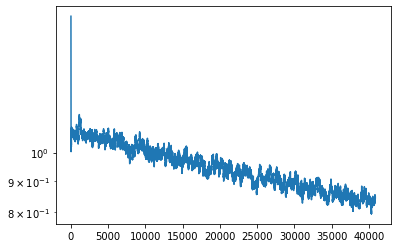

In [ ]:
pd.Series(losses).ewm(100).mean().plot();
plt.yscale('log');

In [ ]:
model.save_pretrained(save_model_path)
tokenizer.save_pretrained(save_model_path)

('/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-qm-ru-v1/tokenizer_config.json',
 '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-qm-ru-v1/special_tokens_map.json',
 '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-qm-ru-v1/sentencepiece.bpe.model',
 '/Til/MyDrive/Colab Notebooks/Til/models/qm/mbart-large-52-qm-ru-v1/added_tokens.json')

In [ ]:
model.eval();

In [ ]:
qm, ru = random.choice(all_pairs)
qm, ru

('Бир jол мубарек алий–эпенди ай толgунчу, суwлу qолну qоюb, суwсузла башына барgан эди.',
 'Однажды праведный алий–эфенди еще до полнолуния, оставив суулу–кол, отправился на суусузла–баши.')

In [ ]:
def translate(text, src='qm_XX', trg='ru_RU', max_length=200, num_beams=5, repetition_penalty=5.0, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(text, return_tensors="pt")
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]

In [ ]:
translate(qm)

'Однажды стройный алий–эфенди, когда наступал месяц, оставляя свою водную руку, возвращался на вершину безбородых.'

In [ ]:
loss = None
optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()

# Evaluate

In [ ]:
!ls /Til/MyDrive/Colab Notebooks/Til/Data/

ls: cannot access '/Til/MyDrive/Colab': No such file or directory
ls: cannot access 'Notebooks/Til/Data/': No such file or directory


In [ ]:
dev_s = pd.read_csv('/Til/MyDrive/Colab Notebooks/Til/Data/Bary_besh_to_model.csv')
dev = list()
for i in range(20):
    dev.append(dev_s.iloc[i].tolist())

In [ ]:
translate('Къалайса?')

'Ты против?'

In [ ]:
from sacrebleu import CHRF, BLEU
chrf_calc = CHRF(word_order=2)
bleu_calc = BLEU()

In [ ]:
for k in range(len(dev)):
    s = chrf_calc.corpus_score(translate(dev[k][0]), [dev[k][1]]).score
    print(f'{k} {s:2.2f}')

0 4.57
1 4.99
2 2.34
3 8.69
4 5.41
5 3.28
6 6.84
7 7.48
8 6.31
9 8.57
10 6.84
11 6.04
12 9.99
13 3.10
14 4.31
15 5.29
16 7.07
17 11.09
18 3.83
19 13.70


In [ ]:
print(chrf_calc.corpus_score(
    [t for k in range(len(dev)) for t in translate(dev[k][0])], 
    [[t for k in range(len(dev)) for t in dev[k][1]]]
).score)

4.5686386820500235


# Translate the monolingual corpus for back-translation

In [ ]:
cleanup()

In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/myv_mono.v1.json', 'r') as f:
    all_sentences = json.load(f)
print(len(all_sentences))
random.seed(1)
random.shuffle(all_sentences)

333651


In [ ]:
def translate_batch(texts, src='myv_XX', trg='ru_RU', max_length='auto', num_beams=5, repetition_penalty=5.0, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt")
    if max_length == 'auto':
        max_length = int(10 + encoded.input_ids.shape[1] * 1.5)
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)


In [ ]:
translate_batch(all_sentences[:4])

['Приветствую тебя, Хоразин! Приветствую тебя, Бетсаида! Если бы народ Тирский и Сидонский видел чудеса, которые явились вам, то они уже давно одевались в одежду скорби и не сидели бы над кулупами.',
 'Здесь работающих — эти естественные условия, сбор съедобных грибов.',
 'Включает в себя Адамсон Генрих, где открылся Музей чисел Койдула.',
 'Сплыть, девочки!']

In [ ]:
batch_size = 16

In [ ]:
all_translated = []

[]

In [ ]:
cleanup()


for i in trange(0, len(all_sentences), batch_size):
    batch = all_sentences[i: i + batch_size]
    if all_translated[i: i + batch_size]:
        continue
    try:
        all_translated.extend(translate_batch(batch))
    except RuntimeError:
        print('error at', i)
        cleanup()
        bb = []
        for b in batch:
            try:
                bb.append(translate_batch([b])[0])
            except RuntimeError:
                print('mega error!')
                bb.append(b)
                cleanup()
        all_translated.extend(bb)

    if i and (i // batch_size) % 100 == 0:
        with open('/gd/MyDrive/datasets/nlp/myv_corpus/myv_mono.v1.back_translated.v1.json', 'w') as f:
            json.dump({'original': all_sentences, 'translated': all_translated}, f, ensure_ascii=False, indent=2)
        print(i, 'saving...')

  0%|          | 0/20854 [00:00<?, ?it/s]

40000 saving...
41600 saving...
43200 saving...
44800 saving...
46400 saving...
48000 saving...
49600 saving...
51200 saving...
52800 saving...
54400 saving...
56000 saving...
57600 saving...
59200 saving...
60800 saving...
62400 saving...
64000 saving...
65600 saving...
67200 saving...
68800 saving...
70400 saving...
72000 saving...
73600 saving...
75200 saving...
76800 saving...
78400 saving...
80000 saving...
81600 saving...
83200 saving...
84800 saving...
86400 saving...
88000 saving...
89600 saving...
91200 saving...
92800 saving...
94400 saving...
96000 saving...
97600 saving...
99200 saving...
100800 saving...
102400 saving...
104000 saving...
105600 saving...
107200 saving...
108800 saving...
110400 saving...
112000 saving...
113600 saving...
115200 saving...
116800 saving...
118400 saving...
120000 saving...
121600 saving...
123200 saving...
124800 saving...
126400 saving...
128000 saving...
129600 saving...
131200 saving...
132800 saving...
134400 saving...
136000 saving...
1

In [ ]:
with open('/gd/MyDrive/datasets/nlp/myv_corpus/myv_mono.v1.back_translated.v1.json', 'w') as f:
    json.dump({'original': all_sentences, 'translated': all_translated}, f, ensure_ascii=False, indent=2)